In [89]:
import time

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from src.datasets import SyntheticSpikes
from src.snn.snn import SNN
from src.snn.block.blocks import Blocks

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model equivalence

Let's check if the blocks model and the standard model produce the same output raster

In [86]:
n_in = 100
n_out = 20
rf_len = 20
t_len = 1000 
block_len = 40

# Instantiate recurrently connected ALIF SNNs (blocks and standard version)
torch.manual_seed(42)
input_raster = SyntheticSpikes(t_len, n_in, min_r=0, max_r=100, n_samples=1)[0]
standard_snn = SNN(n_in, n_out, rf_len, t_len, t_latency=block_len, recurrent=True, init_beta=0.99, init_p=0.99)
blocks_snn = Blocks(n_in, n_out, rf_len, t_len, t_latency=block_len, recurrent=True, init_beta=0.99, init_p=0.99)

# Ensure bocks model has the same weights as the standard model
blocks_snn._rf_weight = standard_snn._rf_weight
blocks_snn._rf_bias = standard_snn._rf_bias
blocks_snn._rec_weight = standard_snn._rec_weight

# Obtain spikes from blocks and standard model
with torch.no_grad():
    blocks_spikes = blocks_snn(input_raster.unsqueeze(0), mode="train")
    standard_spikes = standard_snn(input_raster.unsqueeze(0), mode="train")

In [62]:
# Drum roll, the moment we have all been waiting for...
print(f"Are model outputs the same? {torch.allclose(blocks_spikes, standard_spikes)}")

Are model outputs the same? True


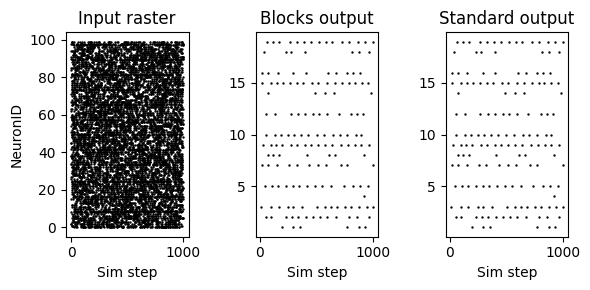

In [88]:
# Little util function
def spike_tensor_to_points(spike_tensor):
    x = np.array([p[1].item() for p in torch.nonzero(spike_tensor.cpu())])
    y = np.array([p[0].item() for p in torch.nonzero(spike_tensor.cpu())])
    
    return x, y

fig, axs = plt.subplots(1, 3, figsize=(6, 3))
axs[0].scatter(*spike_tensor_to_points(input_raster), color="black", s=0.5)
axs[1].scatter(*spike_tensor_to_points(blocks_spikes[0]), color="black", s=0.5)
axs[2].scatter(*spike_tensor_to_points(standard_spikes[0]), color="black", s=0.5)
axs[0].set_title("Input raster")
axs[1].set_title("Blocks output")
axs[2].set_title("Standard output")
axs[0].set_ylabel("NeuronID")
axs[0].set_xlabel("Sim step")
axs[1].set_xlabel("Sim step")
axs[2].set_xlabel("Sim step")
fig.tight_layout()

## Model speed

How much faster is our blocks models model?

In [108]:
def get_training_duration(model, device="cpu"):
    model = model.to(device)
    data = input_raster.unsqueeze(0).to(device).repeat(128, 1, 1)  # 128 batch size
    torch.cuda.synchronize()
    start_time = time.time()
    output = model(data)
    loss = output.sum()  # Arbitraty loss just so we have something to backpropogate
    loss.backward()
    torch.cuda.synchronize()
    training_duration = time.time() - start_time
    return training_duration

In [103]:
def get_training_durations_for_both_models(device):
    standard_training_times = [get_training_duration(standard_snn, device) for _ in range(11)][1:]
    block_training_times = [get_training_duration(blocks_snn, device) for _ in range(11)][1:]
    return pd.DataFrame({"standard": standard_training_times, "block": block_training_times})

In [104]:
torch.backends.cudnn.benchmark = True  # Make sure we use the best conv algorithm

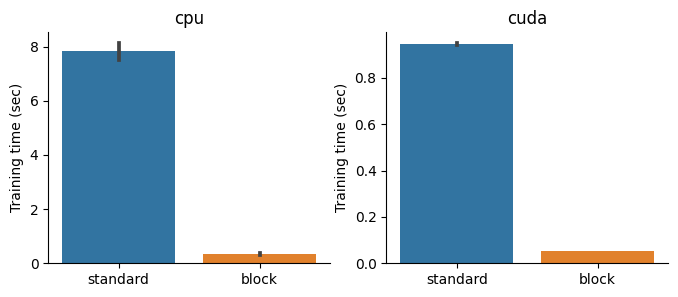

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=False)

def plot_training_durations(ax, device):
    sns.barplot(get_training_durations_for_both_models(device), ax=ax)
    ax.set(ylabel="Training time (sec)", title=device)
    sns.despine()
    
plot_training_durations(axs[0], "cpu")
plot_training_durations(axs[1], "cuda")

Voila! A condsiderable reduction in training time, on both CPUs and GPUs!